# Solutions Assignments 5

## Imports


In [1]:
import os
from functools import reduce
from pathlib import Path as P

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data as data_utils
from torch.utils.tensorboard import SummaryWriter

import torchvision as tv

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec 
import matplotlib.patches as patches
import seaborn as sn
from sklearn.metrics import confusion_matrix

import yaml

import math

import copy

from tqdm import tqdm

import optuna

import pandas as pd

import plotly

from fvcore.nn import FlopCountAnalysis, flop_count_str, ActivationCountAnalysis

import ipdb

import inspect

import torchgadgets as tg

from dataset import KTHActioNDataset

## Data

In [2]:
DATA_DIR = '/home/nfs/inf6/data/dataset/kth_actions'

train = [11, 12, 13, 14, 15, 16, 17, 18]
validation =[19, 20, 21, 23, 24, 25, 1, 4]
test = [22, 2, 3, 5, 6, 7, 8, 9, 10]


In [3]:
train_dataset = KTHActioNDataset(dataset_name='kth_actions', split='train')
test_dataset = KTHActioNDataset(dataset_name='kth_actions', split='test')
        

IndexError: index 10 is out of bounds for axis 0 with size 10

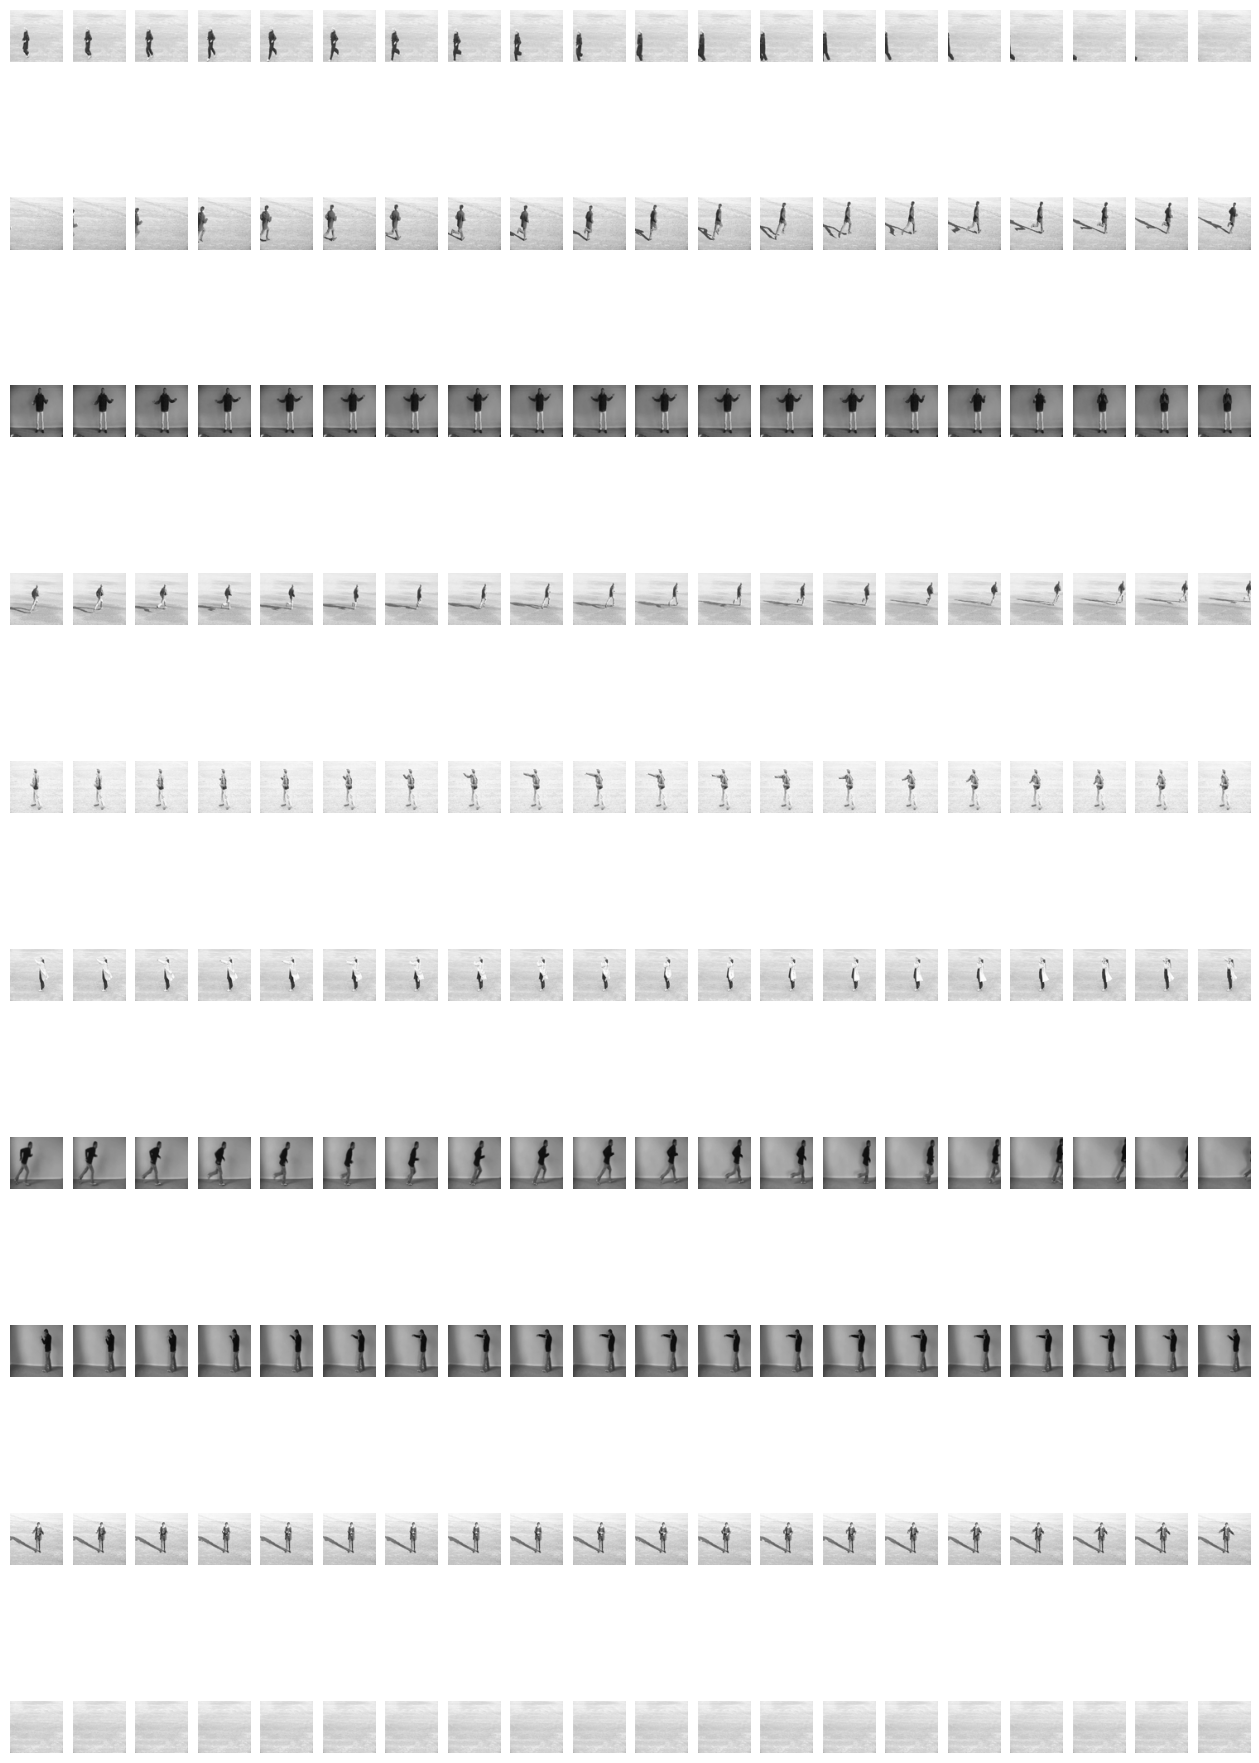

In [12]:
tg.set_random_seed(1234)

seq_length = 20

fig, ax = plt.subplots(10,seq_length, figsize=(16,24))

dl = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)

for i, (img_seq, label) in enumerate(dl):
    if i == seq_length:
        break
    img_seq = img_seq.squeeze()
    label = label.squeeze()
    for j in range(seq_length):
        ax[i][j].imshow(img_seq[j].permute(1,2,0))
        ax[i][j].axis('off')

fig.show()

## Task 1: Implementation of a LSTM/LSTM-Cell

### LSTM-Cell

In [ ]:
class LSTMCell(nn.Module):
    """
        Implementation of a LSTM cell. For computational efficiency, we use a vectorized version of the implementation.
        This reduces the number of matrix multiplication to two. All further values can be computed by taking slices of the so called Concatenated Gate Matrix.
        Formulas:
            A_t = W @ x_t + U @ h_{t-1} (Concatenated Gate Matrix)
            i_t = sigmoid(A_t[:,0:hidden_size])
            f_t = sigmoid(A_t[:,hidden_size:2*hidden_size])
            o_t = sigmoid(A_t[:,2*hidden_size:3*hidden_size])
            g_t = tanh(A_t[:,3*hidden_size:4*hidden_size])
            c_t = f_t * c_{t-1} + i_t * g_t
            h_t = o_t * tanh(c_t)
    """

    def __init__(self, input_size, hidden_size):
        """
            Initialize LSTM cell and all weights. The weights are also re-written in a vectorized variation.
        
        """
        super().__init_()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.weights_ih = nn.Parameter(torch.Tensor(input_size, 4 * hidden_size))
        self.weights_hh = nn.Parameter(torch.Tensor(hidden_size, 4 * hidden_size))
        self.bias = nn.Parameter(torch.Tensor(4 * hidden_size))
        self.reset_parameters()
    
    
    def forward(self, input:torch.Tensor, hidden_state = None):
        """
            Forward pass of a single LSTM cell. We simply compute the formuals shown above.
        """

        if len(input.shape) == 1:
            input = input.unsqueeze(0)
        
        batch_size = input.shape[0]
        
        if hidden_state is None:
            h_t, c_t = torch.zeros(batch_size, self.hidden_size), torch.zeros(batch_size, self.hidden_size)
        else:
            h_t, c_t = hidden_state
        
        A_t = torch.matmul(input, self.weights_ih) + torch.matmul(h_t, self.weights_hh) + self.bias
        i_t = torch.sigmoid(A_t[:,0:self.hidden_size])
        f_t = torch.sigmoid(A_t[:,self.hidden_size:2*self.hidden_size])
        o_t = torch.sigmoid(A_t[:,2*self.hidden_size:3*self.hidden_size])
        g_t = torch.tanh(A_t[:,3*self.hidden_size:4*self.hidden_size])
        c_t = f_t * c_t + i_t * g_t
        h_t = o_t * torch.tanh(c_t)

        return h_t, c_t
        
    def reset_parameters(self) -> None:
        """
            This function was adapted from: https://github.com/pytorch/pytorch/
            We followed this method as it seems a reasonable way of initializing the weights

        """
        stdv = 1.0 / math.sqrt(self.hidden_size) if self.hidden_size > 0 else 0
        for weight in self.parameters():
            weight.uniform_(-stdv, stdv)

### LSTM

## Task 2: Recurrent Model


In [ ]:
RNN_MODEL_CONFIG = 